#Classification

##1. Cross Entropy Loss

##2. Binary Cross Entropy(BCE)

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

torch.manual_seed(0)
X, y = make_classification(n_samples=500,n_features=10,n_informative=8,random_state=0)
Xtr,Xts,ytr,yts = train_test_split(torch.tensor(X).float(),torch.tensor(y).float().unsqueeze(1),test_size=0.2,random_state=0)

class Net(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.linear = nn.Sequential(
        nn.Linear(10,64),
        nn.ReLU(),
        nn.Linear(64,1)
    )
  def forward(self,x):return self.linear(x)

def run_b(loss_fn) :
  net = Net()
  optimizer = optim.AdamW(net.parameters(),lr = 1e-3)
  epochs = 10
  for epoch in range(epochs):
    optimizer.zero_grad()
    pred = net(Xtr)
    loss = loss_fn(pred,ytr)
    loss.backward()
    optimizer.step()
  with torch.no_grad():
    p = torch.sigmoid(net(Xts))
    acc =((p>0.5).float() == yts).float().mean().item()
  return acc

#BEC has already sigmoid function, so don't need it while mse is that we force to put in it to calculate

acc_mse = run_b(lambda out, y : nn.MSELoss()(torch.sigmoid(out),y))
acc_bce = run_b(nn.BCEWithLogitsLoss())
print(f"Binary Acc: MSE={acc_mse:.3f} vs BCEWithLogits={acc_bce:.3f}")
print("this result indicates that BCE has better performance than MSE ")


Binary Acc: MSE=0.780 vs BCEWithLogits=0.660
this result indicates that BCE has better performance than MSE 


##3. CrossEntropy



100%|██████████| 9.91M/9.91M [00:00<00:00, 20.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.7MB/s]


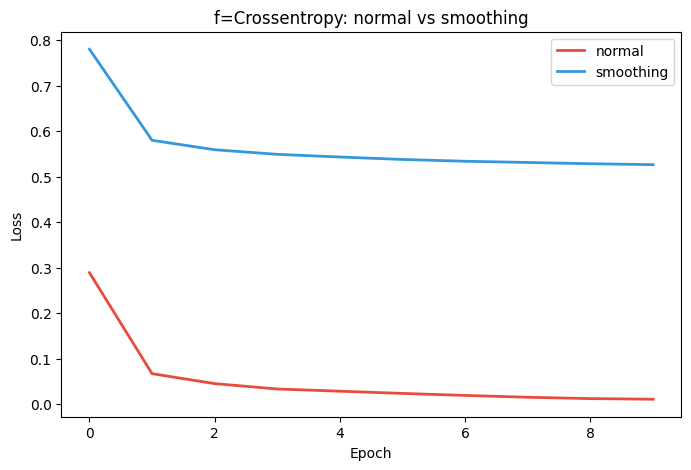

MNIST Acc: LabelSmoothing=0.992 | WeightedCE=0.988


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([transforms.ToTensor()])
tr = datasets.MNIST('/temp/mnist2', train=True, download=True, transform=transform)
ts = datasets.MNIST('/temp/mnist2', train=False, download=True, transform=transform)
tr = DataLoader(tr, batch_size=256,shuffle=True)
ts = DataLoader(ts, batch_size=256, shuffle=False)

class CNN(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1,16,3,padding=1),nn.ReLU(),nn.MaxPool2d(2),
        nn.Conv2d(16,32,3,padding=1),nn.ReLU(),nn.MaxPool2d(2),
        nn.Flatten(),nn.Linear(32*7*7,128),nn.ReLU(),nn.Linear(128,10)
    )
  def forward(self,x): return self.net(x)

result = {}

def run_c(name,loss_fn):
  model = CNN().to(device)
  optimizer = optim.AdamW(model.parameters(),lr=2e-3)
  losses = []
  for epoch in range(10):
    total_loss = 0
    for x,y in tr :
      x,y = x.to(device),y.to(device)
      optimizer.zero_grad()
      pred = model(x)
      loss = loss_fn(pred,y)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    losses.append(total_loss/len(tr))
  result[name] = losses

  model.eval();
  correct = 0; tot = 0
  with torch.no_grad():
    for x,y in ts :
      x,y = x.to(device),y.to(device)
      pred = model(x).argmax(1)
      correct += (pred==y).sum().item(); tot += y.size(0)
  return correct/tot


acc_cross_normal = run_c("normal",nn.CrossEntropyLoss())
acc_cross_smoothing = run_c("smoothing",nn.CrossEntropyLoss(label_smoothing=0.1))

colors = ['#e74c3c', '#3498db', '#2ecc71']
plt.figure(figsize=(8,5))
for (name, loss),color in zip(result.items(),colors) :
  plt.plot(loss,label = name,linewidth=2,color=color)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("f=Crossentropy: normal vs smoothing")
plt.legend()
plt.show()

print(f"MNIST Acc: LabelSmoothing={acc_cross_smoothing:.3f} | WeightedCE={acc_cross_normal:.3f}")


#Regression

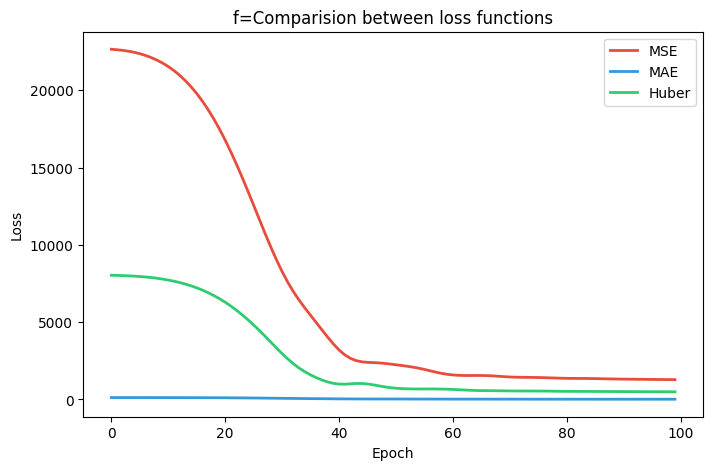

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#generate input data randomly mixing noise to figure out affect of outlier
X,y = make_regression(n_samples = 500, n_features = 10, noise = 10.0, random_state=42)
n_outliers = int(0.1 * len(y))
outlier_indicies = np.random.choice(len(y),n_outliers,replace=False)
y[outlier_indicies] += np.random.randn(n_outliers) * 100

Xtr,Xts,ytr,yts = train_test_split(X,y,test_size=0.2,random_state=42)
# Normalization
scaler = StandardScaler()
Xtr = scaler.fit_transform(Xtr)
Xts = scaler.transform(Xts)
#Convert to tensor
Xtr = torch.tensor(Xtr).float()
Xts = torch.tensor(Xts).float()
ytr = torch.tensor(ytr).float().unsqueeze(1)
yts = torch.tensor(yts).float().unsqueeze(1)

class RegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
        nn.Linear(10,64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,1)
    )

  def forward(self,x):
    return self.linear(x)


loss_sets = {
    "MSE" : nn.MSELoss(),
    "MAE" : nn.L1Loss(),
    "Huber" : nn.HuberLoss(delta = 100)
}
result = {}
num_epochs= 100

for name, cr in loss_sets.items():
  model = RegressionModel()
  optimizer = optim.Adam(model.parameters(),lr = 0.01)
  train_losses = []

  for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(Xtr)
    loss = cr(pred,ytr)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

  result[name] = train_losses
colors = ['#e74c3c', '#3498db', '#2ecc71']
plt.figure(figsize=(8,5))
for (name,losses), color in zip(result.items(), colors):
  plt.plot(losses ,label = name, linewidth=2,color=color)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("f=Comparision between loss functions")
plt.legend()
plt.show()

##1. Mean Squared Error(MSE)

In [ ]:
nn.MSELoss()

##2. Mean Absolute Error(L1)

In [ ]:
nn.L1Loss()

##3.Huber Loss(Smooth L1)

In [ ]:
nn.HuberLoss(delta = delta)
# delta is the boundary between MAE and MSE

# Distance,Metric,Similarity

##1. Cosine Embedding Loss

##2. Tripet Loss

##3. Constrastive Loss

# Distribution

## KL Divergence